# Libreta con el objetivo de predecir sobre un conjunto de datos

In [7]:
import pandas as pd
import numpy as np
import pickle
import math

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

In [3]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy primer modelo: {}'.format(round(accuracy_score(y, y_pred), 3)))

In [50]:
#Cargamos los datos
df_minsait = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_minsait.shape[0])
print("Número de variables: %d" % df_minsait.shape[1])

Tamaño del conjunto de datos:  103230
Número de variables: 55


In [61]:
#Obtenemos una decima parte de los datos de la clase residencial desordenados
df_pruebas = df_minsait[df_minsait['CLASE']=='RESIDENTIAL'].sample(frac=0.01, random_state=10)
#Concatenamos los datos del resto de etiquetas
df_pruebas = df_pruebas.append(df_minsait[df_minsait['CLASE']=='INDUSTRIAL'].sample(frac=0.2, random_state=10))
df_pruebas = df_pruebas.append(df_minsait[df_minsait['CLASE']=='PUBLIC'].sample(frac=0.2, random_state=10))
df_pruebas = df_pruebas.append(df_minsait[df_minsait['CLASE']=='OFFICE'].sample(frac=0.2, random_state=10))
df_pruebas = df_pruebas.append(df_minsait[df_minsait['CLASE']=='RETAIL'].sample(frac=0.2, random_state=10))
df_pruebas = df_pruebas.append(df_minsait[df_minsait['CLASE']=='AGRICULTURE'].sample(frac=0.2, random_state=10))
df_pruebas = df_pruebas.append(df_minsait[df_minsait['CLASE']=='OTHER'].sample(frac=0.2, random_state=10))
#Desordenamos el conjnto de datos
df_pruebas = df_pruebas.sample(frac=1, random_state=10)
display(df_pruebas.shape)
display(df_pruebas['CLASE'].value_counts())

(3514, 55)

RESIDENTIAL    902
INDUSTRIAL     898
PUBLIC         595
RETAIL         419
OFFICE         366
OTHER          266
AGRICULTURE     68
Name: CLASE, dtype: int64

In [60]:
def predict(df):
    def process_cadastral_quality(df):
        dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
        return df

    def process_max_building_floor(df):
        df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
        return df

    def assing_class(df):
        df['SUBCLASE'] = (df['CLASE'] == 'RESIDENTIAL').astype(int)

    process_cadastral_quality(df)
    process_max_building_floor(df)
    assing_class(df)

    #Para nuestro primer modelo vamos a usar todas las variables
    X = df[df.columns[:-2]].copy()
    y = df['SUBCLASE'].copy()

    ### Cargamos el modelo y predecimos
    model_bin = pickle.load(open('./models/binary_smote_15_03_xgboost_20_100.pkl', 'rb'))
    result = model_bin.score(X, y)
    y_pred = model_bin.predict(X)
    show_results(y, y_pred)
    print(classification_report(y, y_pred))
    
    #Obtención de los registros no residenciales y residenciales
    list_ids_no_residential = X[y_pred==0].index.tolist()
    df_no_resident = df[df.index.isin(list_ids_no_residential)]
    df_resident = df[~df.index.isin(list_ids_no_residential)]
    y_resident = df_resident['CLASE']
    
    X_val = df_no_resident[df_no_resident.columns[:-2]].copy()
    y_val = df_no_resident['CLASE'].copy()
    
    #Cargamos el segundo modelo y predecimos
    model_bin = pickle.load(open('./models/multiclass_14_03.pkl', 'rb'))
    result = model_bin.score(X_val, y_val)
    y_val_pred = model_bin.predict(X_val)

    sns.heatmap(confusion_matrix(y_val, y_val_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    target_names = y_val.unique()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names, rotation=0)
    plt.show()
    print("Resultados")
    print('Accuracy segundo modelo:\n {}'.format(round(accuracy_score(y_val, y_val_pred), 3)))
    print(classification_report(y_val, y_val_pred))
    
    # Lo convertimos en serie para tener referenciado el ID
    y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
    all_data_pred = y_resident.append(y_no_resident)
    all_data_pred = all_data_pred[df.index] #Insertamos el orden del original
    print('Accuracy final de predecir:\n \033[1m{}\033[0m'.format(accuracy_score(df['CLASE'], all_data_pred)))
          
    df_prediction = pd.concat([df['CLASE'], all_data_pred], axis=1)
    df_prediction.rename(columns={0: 'PREDICCIÓN'}, inplace=True)
    return df_prediction

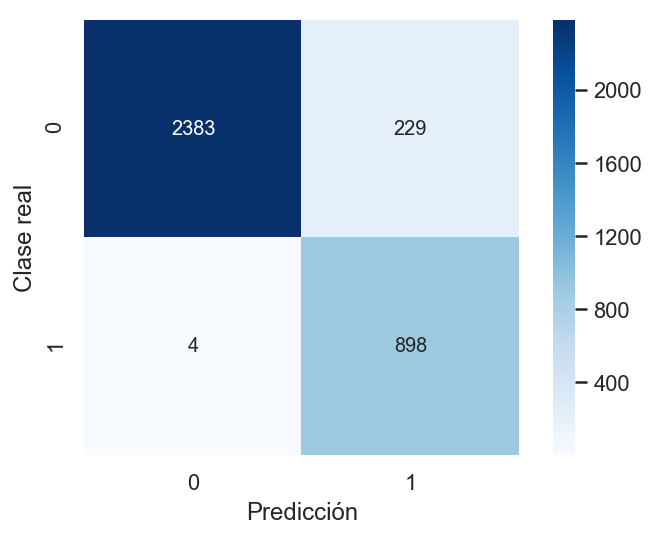

Resultados
Accuracy: 0.934
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2612
           1       0.80      1.00      0.89       902

    accuracy                           0.93      3514
   macro avg       0.90      0.95      0.92      3514
weighted avg       0.95      0.93      0.94      3514



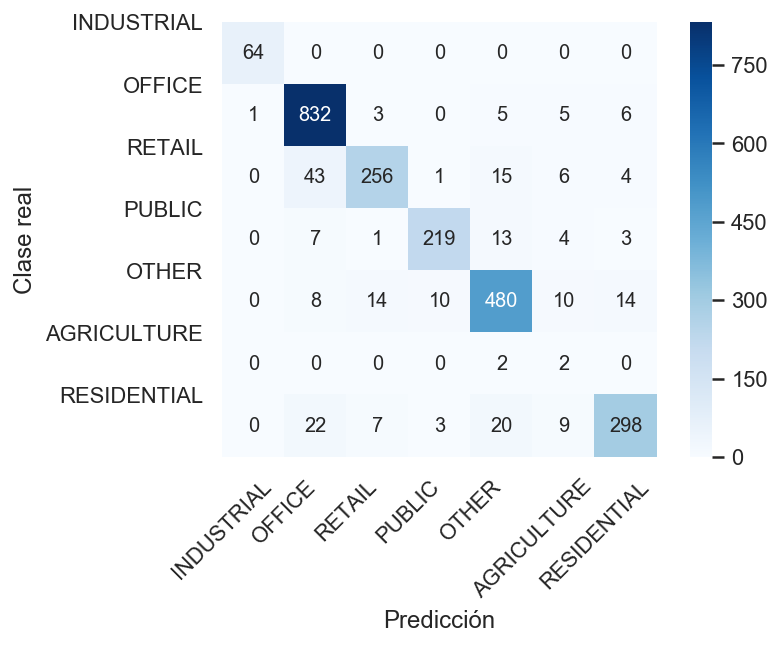

Resultados
Accuracy segundo modelo:
 0.901
              precision    recall  f1-score   support

 AGRICULTURE       0.98      1.00      0.99        64
  INDUSTRIAL       0.91      0.98      0.94       852
      OFFICE       0.91      0.79      0.84       325
       OTHER       0.94      0.89      0.91       247
      PUBLIC       0.90      0.90      0.90       536
 RESIDENTIAL       0.06      0.50      0.10         4
      RETAIL       0.92      0.83      0.87       359

    accuracy                           0.90      2387
   macro avg       0.80      0.84      0.79      2387
weighted avg       0.91      0.90      0.91      2387

Accuracy final de predecir:
 0.9328400682982356


In [62]:
prediccion = predict(df_pruebas)

In [43]:
df_prediction.head()

,CLASE,PREDICCIÓN
ID,,
35984B9C3E7CD9A1,RESIDENTIAL,RESIDENTIAL
F9D04BF6D037F8FB,RESIDENTIAL,RESIDENTIAL
B89D5711AFF8C423,RESIDENTIAL,RESIDENTIAL
1C3478AC1522E7E4,RESIDENTIAL,RESIDENTIAL
4D12AA5009064345,RESIDENTIAL,RESIDENTIAL


---

# Prediccion de los valores a predecir junto con la generación del fichero

In [55]:
#Cargamos los datos
df_minsait_estimate = pd.read_csv('data/Estimar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_minsait_estimate.shape[0])
print("Número de variables: %d" % df_minsait_estimate.shape[1])
if df_minsait_estimate.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')
df_minsait_estimate.head()

Tamaño del conjunto de datos:  5618
Número de variables: 54
El índice es único.


,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID
ID,,,,,,,,,,,,,,,,,,,,,
44198C2A811A4DF4,2200905624,165480229,0.000001,445.999637,634.001172,780.000568,902.004053,1025.997009,1157.997681,1304.999585,...,2545.997754,6803.875107,283.593030,0.046741,0.014588,0.011298,0.774503,1994,5.0,4
216F638609E0E39E,2207436564,165625751,0.000000,385.000995,580.005762,737.004449,873.996460,1005.998779,1141.001758,1296.997083,...,2220.990137,5544.670485,357.712450,0.378483,0.041085,0.025753,0.626835,1968,8.0,3
FFFCEFB11E257364,2200313961,165752898,0.000000,343.996613,567.010620,745.995483,900.997925,1051.995361,1200.006226,1370.990234,...,2421.002441,8827.104856,160.979017,0.306545,0.034637,0.054977,1.587207,1968,5.0,7
596C5C8CE10BCF,2199220382,166288192,0.000000,173.999956,218.000000,261.999713,315.999951,408.000565,560.000500,700.697351,...,2752.005786,7734.759269,9088.678448,0.338955,0.006846,0.005448,0.795725,1993,6.0,6
F931B9FA2A8641D1,2209143550,165253334,0.000007,588.002014,738.999451,848.001282,954.000244,1074.000183,1228.998291,1416.999817,...,2712.997681,7435.991490,994.424368,0.581476,0.036470,0.016033,0.439638,1964,4.0,7


In [56]:
def estimate(df):
    def process_cadastral_quality(df):
        dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)
        return df

    def process_max_building_floor(df):
        df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True)
        return df
    
    def calculate_distance_to_center(df):
        def distance(p0, p1):
            return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)
        center_x = df['X'].sum()/len(df['X'])
        center_y = df['Y'].sum()/len(df['Y'])
        df['distance_to_center'] = df.apply(lambda r: distance([r['X'], r['Y']], [center_x, center_y]), axis=1)
        df['distance_to_center'] = df['distance_to_center'] / df['distance_to_center'].max() #Normalizamos 0,1
        return df
    
    def calculate_context_class(df):
        neigh = pickle.load(open('knn_CCG.model', 'rb'))
        predict = neigh.predict_proba(df[['X', 'Y']])
        aux = pd.DataFrame(predict*5, columns=[ 'C_'+c for c in neigh.classes_ ], index=df.index)
        df = df.merge(aux, on='ID', how='inner') 
        df.drop(columns=['X', 'Y'], inplace=True)
        return df
    
    process_cadastral_quality(df)
    process_max_building_floor(df)
    calculate_distance_to_center(df)
    #df = calculate_context_class(df)
    
    X = df.copy()
    
    #Cargamos el modelo y predecimos
    model_bin = pickle.load(open('binary_xgboost_CCG.model', 'rb'))
    y_pred = model_bin.predict(X)
    
    list_ids_no_residential = X[y_pred==0].index.tolist()
    y_resident = pd.Series(index=X[y_pred==1].index, data='RESIDENTIAL')
    df_no_resident = df[df.index.isin(list_ids_no_residential)]
    
    #Modelo final
    X_val = df_no_resident.copy()
    model_multi = pickle.load(open('multilabel_rfc_CCG.model', 'rb'))
    y_val_pred = model_multi.predict(X_val)
    
    # Lo convertimos en serie para tener referenciado el ID
    y_no_resident = pd.Series(index=X_val.index, data=y_val_pred)
    all_data_pred = y_resident.append(y_no_resident)
    
    solution = all_data_pred[df.index].reset_index()
    #print(solution)
    #print(all_data_pred.tail())
    
    #Generamos el fichero obtenido de la prediccion con ambos modelos
    np.savetxt('./outputs/Estimar_CCG_07_04.txt', solution.values, fmt='%s', delimiter="|", header="ID|CLASE", encoding='utf-8')
    
    print('Fichero generado correctamente')
    plt.figure(figsize=(12,6))
    sns.countplot(all_data_pred[df.index], order=list_class_order)

Fichero generado correctamente


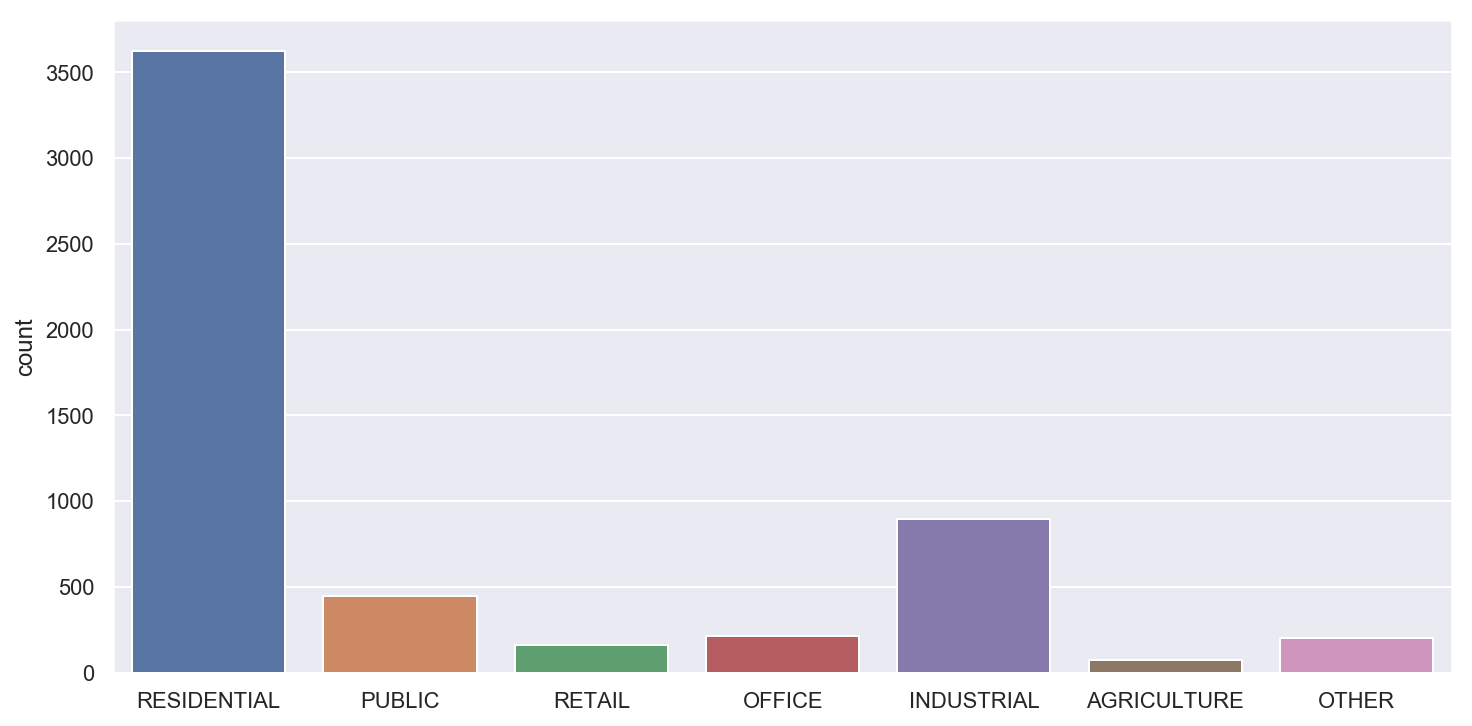

In [57]:
estimate(df_minsait_estimate)

In [58]:
df_concurso = pd.read_csv('./outputs/Estimar_CMBC_0_70_no_PCA.txt', delimiter='|', encoding='utf-8', index_col='ID')
df_now = pd.read_csv('./outputs/Estimar_CCG_07_04.txt', delimiter='|', encoding='utf-8', index_col='ID')

In [59]:
display(df_concurso.head())
display(df_now.head())

,CLASE
ID,
44198C2A811A4DF4,PUBLIC
216F638609E0E39E,RESIDENTIAL
FFFCEFB11E257364,RESIDENTIAL
596C5C8CE10BCF,OFFICE
F931B9FA2A8641D1,OTHER


,CLASE
ID,
44198C2A811A4DF4,RESIDENTIAL
216F638609E0E39E,RESIDENTIAL
FFFCEFB11E257364,RESIDENTIAL
596C5C8CE10BCF,INDUSTRIAL
F931B9FA2A8641D1,OTHER


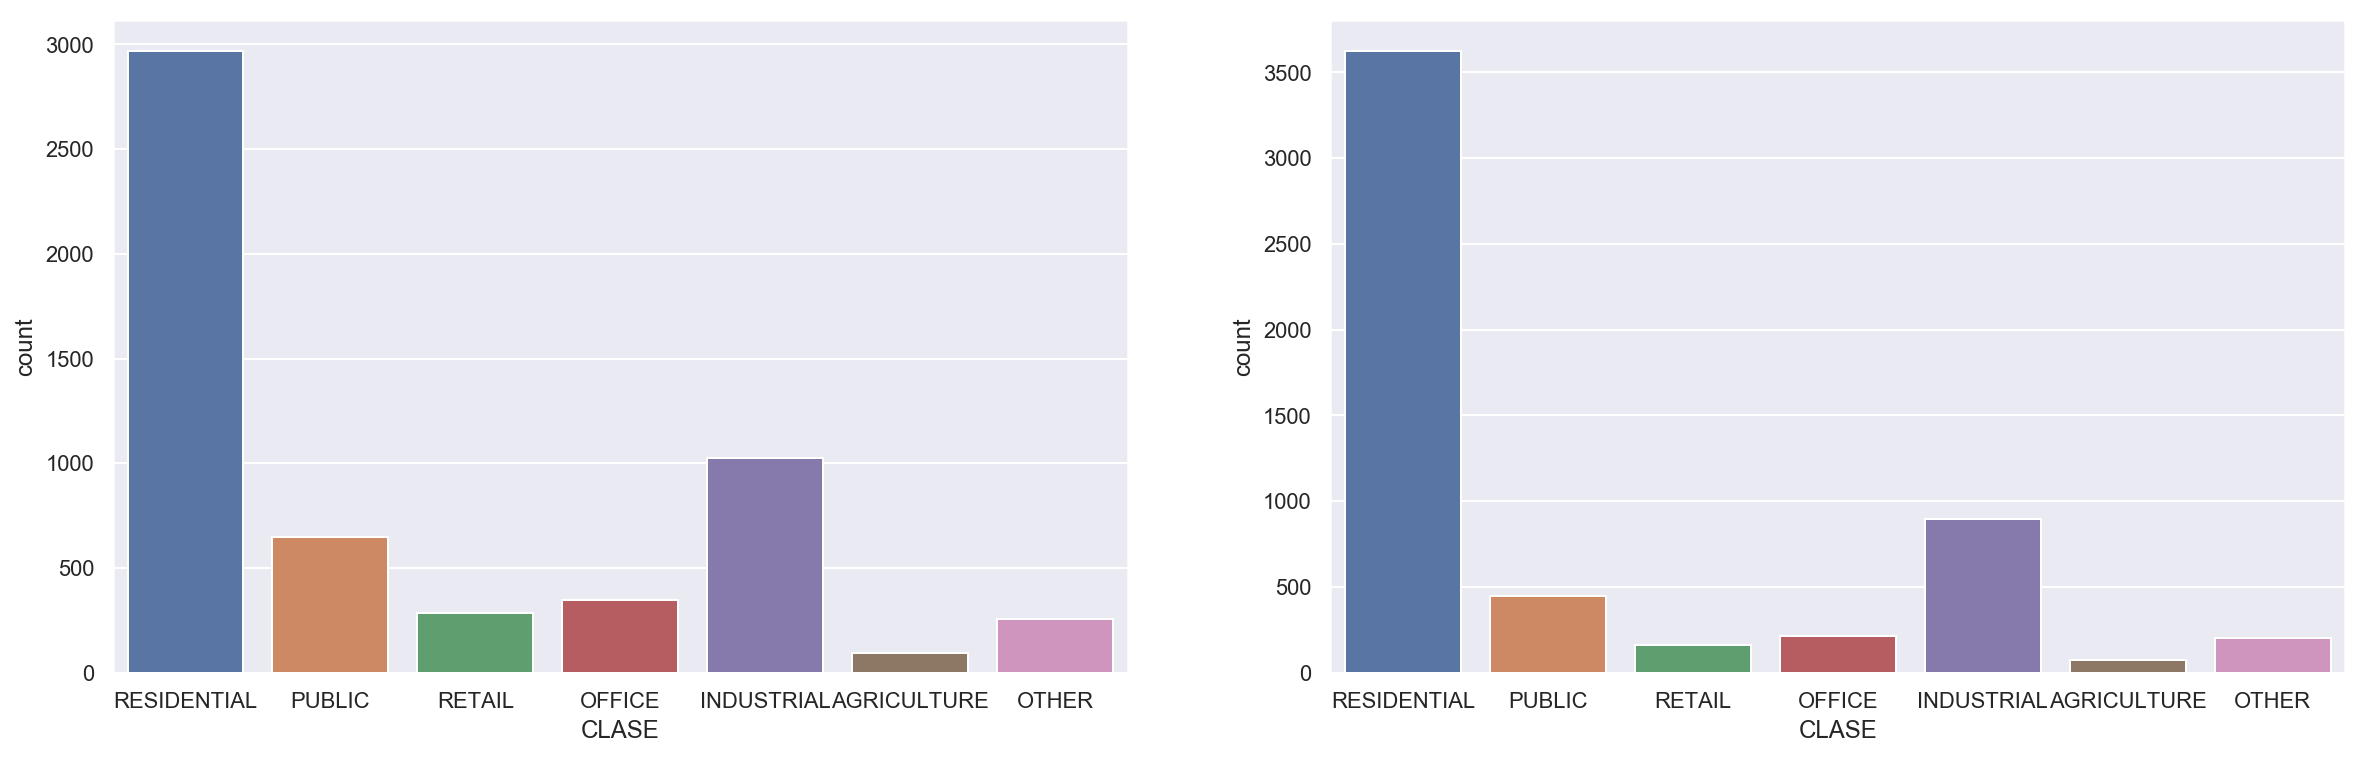

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.countplot(df_concurso.CLASE, order=list_class_order, ax=ax1)
sns.countplot(df_now.CLASE, order=list_class_order, ax=ax2)

In [61]:
print("----Concurso----")
display(df_concurso.CLASE.value_counts())
print("----Nuevo----")
display(df_now.CLASE.value_counts())

----Concurso----


RESIDENTIAL    2967
INDUSTRIAL     1025
PUBLIC          646
OFFICE          348
RETAIL          283
OTHER           257
AGRICULTURE      92
Name: CLASE, dtype: int64

----Nuevo----


RESIDENTIAL    3623
INDUSTRIAL      898
PUBLIC          445
OFFICE          215
OTHER           202
RETAIL          160
AGRICULTURE      75
Name: CLASE, dtype: int64

In [62]:
accuracy_score(df_concurso, df_now)

0.8116767532929868